<a href="https://colab.research.google.com/github/cc-ca/commentaires_toxiques/blob/NN_model/Classification_commentaires_toxiques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des packages

In [3]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.7 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import random

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

from sklearn.utils import class_weight


# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
data_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
data_test = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/test.csv')
data_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
data_test_labels = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/test_labels.csv')
data_test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [ ]:
data_test = pd.merge(data_test, data_test_labels, on = ['id'])

In [ ]:
data_test

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",-1,-1,-1,-1,-1,-1


# Etude du jeu de données

## a. Train Data

On sépare les commentaires des catégories

In [ ]:
X_train = data_train['comment_text']
X_train[59]

"Why can't you believe how fat Artie is? Did you see him on his recent appearence on the Tonight Show with Jay Leno? He looks absolutely AWFUL! If I had to put money on it, I'd say that Artie Lange is a can't miss candidate for the 2007 Dead pool!   \n\n  \nKindly keep your malicious fingers off of my above comment, . Everytime you remove it, I will repost it!!!"

In [ ]:
X_train[50:60]

50    "\n\nBI, you said you wanted to talk\n\nAt the...
51    GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK T...
52    Are you threatening me for disputing neutralit...
53    Thanks! Undeletion was more than I'd hoped for...
54    Awesome! Then I'll simply disregard your notic...
55    Stupid peace of shit stop deleting my stuff as...
56    =Tony Sidaway is obviously a fistfuckee. He lo...
57    "\n\n GA Review II \n\nI'm sorry to say this, ...
58    My Band Page's deletion. You thought I was gon...
59    Why can't you believe how fat Artie is? Did yo...
Name: comment_text, dtype: object

On remarque que la colonne id n’est pas utile pour notre entrainement

In [ ]:
y_train = data_train.drop(columns=['id', 'comment_text'])
y_train[50:60]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
50,0,0,0,0,0,0
51,1,0,1,0,0,0
52,0,0,0,0,0,0
53,0,0,0,0,0,0
54,0,0,0,0,0,0
55,1,1,1,0,1,0
56,1,0,1,0,1,0
57,0,0,0,0,0,0
58,1,0,1,0,0,0
59,1,0,0,0,0,0


In [ ]:
number_of_lines = y_train['toxic'].count()
print('Nombre de donnée : ', number_of_lines)

Nombre de donnée :  159571


In [ ]:
print("Pourcentages des différentes catégories parmi l'ensemble de données")
y_train.sum()/number_of_lines*100

Pourcentages des différentes catégories parmi l'ensemble de données


toxic            9.584448
severe_toxic     0.999555
obscene          5.294822
threat           0.299553
insult           4.936361
identity_hate    0.880486
dtype: float64

## b. Test Data

In [ ]:
# Your Code
X_test = pd.DataFrame(data_test['comment_text'])
X_test[59:60]

,comment_text
59,":Fuck off, you anti-semitic cunt. |"


In [ ]:
X_test[50:60]

,comment_text
50,I have been perfectly civil in what quite clea...
51,*I agree with Billfruge. The author describes ...
52,==Category:Italian Jews== \n\n :Category:Itali...
53,== Someday Never == \n\n Why was the image del...
54,""", 5 December 2012 (UTC) \n\n :::The above is,..."
55,""":I see that you moved to Talat Hamdani. Perh..."
56,I WILL BURN YOU TO HELL IF YOU REVOKE MY TALK ...
57,== Hebrean-Judeo-Christian == \n\n What is Heb...
58,== Can you work your magic? == \n\n Hi. I was...
59,":Fuck off, you anti-semitic cunt. |"


# Préparation des données

In [ ]:
def clean(tweet): 
            
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)  
    
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"yrs", "years", tweet)
    tweet = re.sub(r"hrs", "hours", tweet)
    tweet = re.sub(r"2morow|2moro", "tomorrow", tweet)
    tweet = re.sub(r"2day", "today", tweet)
    tweet = re.sub(r"4got|4gotten", "forget", tweet)
    tweet = re.sub(r"b-day|bday", "b-day", tweet)
    tweet = re.sub(r"mother's", "mother", tweet)
    tweet = re.sub(r"mom's", "mom", tweet)
    tweet = re.sub(r"dad's", "dad", tweet)
    tweet = re.sub(r"hahah|hahaha|hahahaha", "haha", tweet)
    tweet = re.sub(r"lmao|lolz|rofl", "lol", tweet)
    tweet = re.sub(r"thanx|thnx", "thanks", tweet)
    tweet = re.sub(r"goood", "good", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    # Urls
    tweet = re.sub(r"http\S+", "", tweet)
    # Numbers
    tweet = re.sub(r'[0-9]', '', tweet)
    # Eliminating the mentions
    tweet = re.sub("(@[A-Za-z0-9_]+)","", tweet)
    # Remove punctuation and special chars (keep '!')
    for p in string.punctuation.replace('!', ''):
        tweet = tweet.replace(p, '')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')
        
    # Tokenize
    tweet_words = tokenizer.tokenize(tweet)
    
    # Eliminating the word if its length is less than 3
    tweet = [w for w in tweet_words if len(w)>2]
    
    # remove stopwords
    tweet = [w.lower() for w in tweet if not w in stop_words]  
    
    corpus.append(tweet)
    
    # join back
    tweet = ' '.join(tweet)
        
        
    return tweet

In [ ]:
variable_name = ""
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev_in_text(tweet):
    t=[]
    words=tweet.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t) 

In [ ]:
# Your Code
tokenizer = TweetTokenizer(strip_handles=True)
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
corpus = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def prepare_string(tweet):
  tweet = clean(tweet)
  tweet = convert_abbrev_in_text(tweet)
  return tweet

In [ ]:
data_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
%%time
# Apply prepare_string to all rows in 'tweets' column
data_train['comment_text'] = data_train['comment_text'].apply(lambda s : prepare_string(s))

# Drop empty values from dataframe
data_train['comment_text'].replace('', np.nan, inplace=True)
data_train.dropna(subset=['comment_text'], inplace=True)
data_train.drop(columns=["id"])

CPU times: user 1min 38s, sys: 521 ms, total: 1min 39s
Wall time: 1min 52s


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation why edits made username hardcore m...,0,0,0,0,0,0
1,daww matches background colour seemingly stuck...,0,0,0,0,0,0
2,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,more cannot make real suggestions improvement ...,0,0,0,0,0,0
4,you sir hero any chance remember page,0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,and second time asking view completely contrad...,0,0,0,0,0,0
159567,you ashamed that horrible thing put talk page,0,0,0,0,0,0
159568,spitzer umm theres actual article prostitution...,0,0,0,0,0,0
159569,and looks like actually put speedy first versi...,0,0,0,0,0,0


In [ ]:
%%time
# Apply prepare_string to all rows in 'tweets' column
data_test["comment_text"] = data_test["comment_text"].apply(lambda s : prepare_string(s))

# Drop empty values from dataframe
data_test.replace('', np.nan, inplace=True)
data_test.dropna(subset=['comment_text'], inplace=True)
data_test.drop(data_test[data_test['toxic']== -1].index, inplace = True)
data_test.drop(columns=["id"])

CPU times: user 1min 22s, sys: 348 ms, total: 1min 23s
Wall time: 1min 23s


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,thank understanding think highly would revert ...,0,0,0,0,0,0
7,dear god site horrible,0,0,0,0,0,0
11,somebody invariably try add religion really yo...,0,0,0,0,0,0
13,says right type the type institution needed ca...,0,0,0,0,0,0
14,before adding new product list make sure relev...,0,0,0,0,0,0
...,...,...,...,...,...,...,...
153150,jerome see never got around surprised looked e...,0,0,0,0,0,0
153151,lucky bastard heh famous kida envy congrats,0,0,0,0,0,0
153154,shame you want speak gays romanians,0,0,0,0,0,0
153155,mel gibson nazi bitch who makes shitty movies ...,1,0,1,0,1,0


In [ ]:
y_train

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


In [ ]:
X_train

0         explanation why edits made username hardcore m...
1         daww matches background colour seemingly stuck...
2         hey man really trying edit war guy constantly ...
3         more cannot make real suggestions improvement ...
4                     you sir hero any chance remember page
                                ...                        
159566    and second time asking view completely contrad...
159567        you ashamed that horrible thing put talk page
159568    spitzer umm theres actual article prostitution...
159569    and looks like actually put speedy first versi...
159570    and really think understand came idea bad righ...
Name: comment_text, Length: 159571, dtype: object

On exporte nos données pour ne pas avoir a refaire le traitement à chaques executions

In [ ]:
data_train.to_csv('/content/drive/MyDrive/cleaned_comments_train.csv', index=False)
data_test.to_csv('/content/drive/MyDrive/cleaned_comments_test.csv', index=False)

# Moyen de réimporter les données deja préparée au paravant

In [8]:
data_test = pd.read_csv('/content/drive/MyDrive/cleaned_comments_test.csv')
data_train = pd.read_csv('/content/drive/MyDrive/cleaned_comments_train.csv')

In [9]:
X_train = data_train["comment_text"]
y_train = data_train.drop(columns=["comment_text", "id"])
X_test = data_test["comment_text"]
y_test = data_test.drop(columns=["comment_text", "id"])

# Entraînement du modèle Random Forest

In [10]:
tfIdfVectorizer = TfidfVectorizer()
X_train_vect = tfIdfVectorizer.fit_transform(X_train)

In [11]:
# Use only 15 estimator to save your ram
text_classifier = RandomForestClassifier(n_estimators=15,max_depth=100, random_state=0)

# fit
text_classifier.fit(X_train_vect, y_train)

RandomForestClassifier(max_depth=100, n_estimators=15, random_state=0)

In [12]:
X_test_vect = tfIdfVectorizer.transform(X_test)
predictions = text_classifier.predict(X_test_vect)

In [13]:
print(classification_report(y_test, predictions))

print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.06      0.11      6087
           1       1.00      0.01      0.01       367
           2       0.94      0.05      0.09      3688
           3       0.00      0.00      0.00       211
           4       0.92      0.03      0.05      3424
           5       1.00      0.00      0.00       712

   micro avg       0.93      0.04      0.08     14489
   macro avg       0.80      0.02      0.04     14489
weighted avg       0.92      0.04      0.08     14489
 samples avg       0.01      0.00      0.00     14489

0.9024940115541779


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Itération de la modélisation 

Deep learning model

## NN with LSTM

In [51]:
# Creation of tuples (comments, tags associated) in anticipation of data mixing
corpus = list(zip(data_train['comment_text'].values, data_train[["toxic","severe_toxic","obscene","threat", "insult", "identity_hate"]].values))

In [52]:
embedding_dim = 100    # Dimensions used for glov0e6b100
max_length = 20        # Maximum number of word
trunc_type='post'      # Truncates the tweet if it is longer than max_length
padding_type='post'    # Adds padding to the end of the tweet if it is shorter than max_length
oov_tok = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)
training_size=len(corpus)
test_portion=.025

In [56]:
sentences=[]
labels=[]

for x in range(len(corpus)):
    sentences.append(str(corpus[x][0]))
    labels.append(corpus[x][1])

In [64]:
tokenizerDL = Tokenizer()
tokenizerDL.fit_on_texts(sentences)

word_index = tokenizerDL.word_index
vocab_size=len(word_index)

train_sequences = tokenizerDL.texts_to_sequences(sentences)
training_padded = np.array(pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type))

val_corpus = list(zip(data_test['comment_text'].values, data_test[["toxic","severe_toxic","obscene","threat", "insult", "identity_hate"]].values))

val_sentences=[]
val_labels=[]

for x in range(len(val_corpus)):
    val_sentences.append(str(val_corpus[x][0]))
    val_labels.append(val_corpus[x][1])

test_sequences = tokenizerDL.texts_to_sequences(val_sentences)
testing_padded = np.array(pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type))

num_epochs = 10
training_labels = np.array(labels)
test_labels = np.array(val_labels)

model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
                             LSTM(units=64),
                             tf.keras.layers.Dense(6, activation='sigmoid')])


model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tfa.metrics.F1Score(num_classes=6, threshold=0.5)])

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels), batch_size = 256, verbose=1)
  
print("Training Complete")

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['f1_score']
val_acc=history.history['val_f1_score']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation f1-score')
plt.xlabel("Epochs")
plt.ylabel("F1-score")
plt.legend(["F1-score", "Validation Accuracy"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

TypeError: ignored

In [62]:
def predict(L):
  L_text_pred=L
  L = tokenizerDL.texts_to_sequences(L)
  L=np.array(pad_sequences(L, maxlen=max_length, padding=padding_type, truncating=trunc_type))
  LP=model.predict(L)

  L_tags = ["toxic", "severe toxic", "obscene" ,"a threat", "an insult" ,"identity_hate"]
  cpt=0
  


  for x in LP:
    print("\n")
    var=""
    cptb=0
    var=var+L_text_pred[cpt] + ' is '
    cpt=cpt+1
    nothing = True


    for c in x:
      if c> 0.5:
        nothing= False
        var = var + L_tags[cptb] + ' | '
        cptb=cptb+1
        
      else:
        cptb=cptb+1
        
    if nothing:
      var = var + 'not toxic'
    print(var)


On peut mainteant prédire avec une liste de commentaires inscrits dans une liste

In [63]:
predict(['you are a cunt','you were the chosen one', 'go fuck you gay bastard', 'i will kill you'])

1/1 [==============================] - 0s 354ms/step


you are a cunt is toxic | obscene | an insult | 


you were the chosen one is not toxic


go fuck you gay bastard is toxic | severe toxic | obscene | an insult | identity_hate | 


i will kill you is toxic | a threat | 


# NN V1


In [ ]:
max_length = 30

train_sequences = tokenizerDL.texts_to_sequences(sentences)
training_padded = np.array(pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type))

test_sequences = tokenizerDL.texts_to_sequences(val_sentences)
testing_padded = np.array(pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type))

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    LSTM(units=64),
    tf.keras.layers.Dense(6, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tfa.metrics.F1Score(num_classes=6, threshold=0.5)])

In [ ]:
history2 = model.fit(training_padded, 
                      training_labels, 
                      epochs=num_epochs, 
                      validation_data=(testing_padded, test_labels),
                      batch_size = 256,
                      verbose=1)
  
print("Training Complete")

Epoch 1/10
624/624 [==============================] - 61s 94ms/step - loss: 0.1440 - f1_score: 0.0474 - val_loss: 0.0864 - val_f1_score: 0.2986
Epoch 2/10
624/624 [==============================] - 17s 27ms/step - loss: 0.0556 - f1_score: 0.3686 - val_loss: 0.0739 - val_f1_score: 0.3246
Epoch 3/10
624/624 [==============================] - 14s 22ms/step - loss: 0.0414 - f1_score: 0.4011 - val_loss: 0.0789 - val_f1_score: 0.3455
Epoch 4/10
624/624 [==============================] - 11s 18ms/step - loss: 0.0344 - f1_score: 0.4676 - val_loss: 0.0887 - val_f1_score: 0.3884
Epoch 5/10
624/624 [==============================] - 11s 18ms/step - loss: 0.0301 - f1_score: 0.5135 - val_loss: 0.0875 - val_f1_score: 0.3772
Epoch 6/10
624/624 [==============================] - 10s 16ms/step - loss: 0.0261 - f1_score: 0.5679 - val_loss: 0.0952 - val_f1_score: 0.3968
Epoch 7/10
624/624 [==============================] - 11s 17ms/step - loss: 0.0226 - f1_score: 0.6430 - val_loss: 0.1012 - val_f1_score:

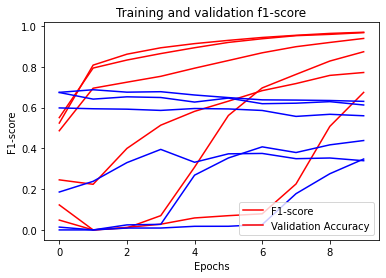

<Figure size 432x288 with 0 Axes>

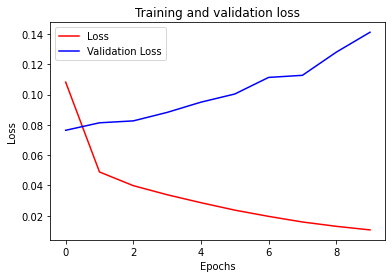

<Figure size 432x288 with 0 Axes>

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['f1_score']
val_acc=history.history['val_f1_score']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation f1-score')
plt.xlabel("Epochs")
plt.ylabel("F1-score")
plt.legend(["F1-score", "Validation Accuracy"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()